In [10]:
import matplotlib.pyplot as plt
from pycbc.detector import Detector
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import combinations
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D
from pycbc.waveform import get_fd_waveform
from pycbc.psd import aLIGOZeroDetHighPower



In [11]:
#LIGO India
class LigoIndia(Detector):
    def __init__(self, name, latitude, longitude, orientation):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.orientation = orientation
        super().__init__(name)
ligo_india_latitude = np.radians(19.613306) 
ligo_india_longitude = np.radians(77.030861)  
ligo_india_orientation = np.radians(45.0)  

detectors = [Detector("L1"),Detector("H1"),Detector("K1"),Detector("V1"),
             LigoIndia("I1", ligo_india_latitude, ligo_india_longitude, ligo_india_orientation)]

detectors = {
    "L1": Detector("L1"),
    "H1": Detector("H1"),
    "K1": Detector("K1"),
    "V1": Detector("V1"),
    "I1": LigoIndia("I1", ligo_india_latitude, ligo_india_longitude, ligo_india_orientation)
}



In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 100000
rho_min = 8
mass1 = 1.5
mass2 = 1.5
distance_ref = 900  # in Mpc
delta_f = 1.0 / 16
f_lower = 20
pol = 0
t = 1e10

ra = np.random.uniform(0, 2 * np.pi, n)
dec = np.pi / 2 - np.arccos(np.random.uniform(-1, 1, n))

# Waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=mass1, mass2=mass2,
                         f_lower=f_lower,
                         delta_f=delta_f,
                         distance=distance_ref)
H_f_squared = abs(hp)**2 + abs(hc)**2


psd = aLIGOZeroDetHighPower(len(hp), hp.delta_f, f_lower)
valid = psd > 0
rho_sq_source = ((H_f_squared[valid] / psd[valid]) * hp.delta_f).sum()

folder = "figures"
os.makedirs(folder, exist_ok=True)


## Visualisation of detection volume

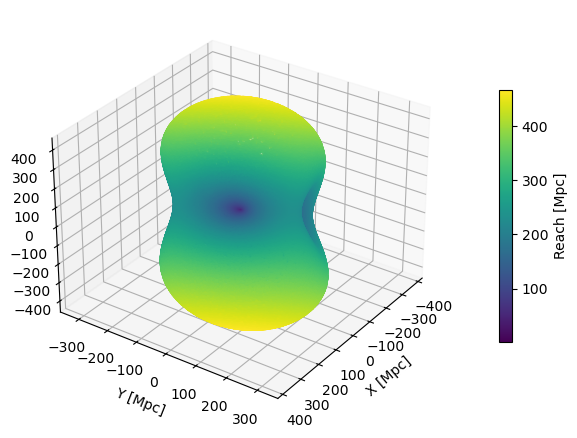

In [18]:
d = Detector("H1")
fp, fc = d.antenna_pattern(ra, dec, pol, t)
proj = 2 * (fp**2 + fc**2)  
rho_sq_total = proj * rho_sq_source
rho_total = np.sqrt(rho_sq_total)

reach = distance_ref * (rho_total / rho_min)

folder = "figures"
os.makedirs(folder, exist_ok=True)


fig = plt.figure(figsize=(10,8 ))
ax = fig.add_subplot(111, projection='3d')

r_plot = reach[:n]
ra_plot = ra[:n]
dec_plot = dec[:n]

# Convert spherical to Cartesian coordinates
x = r_plot * np.cos(dec_plot) * np.cos(ra_plot)
y = r_plot * np.cos(dec_plot) * np.sin(ra_plot)
z = r_plot * np.sin(dec_plot)

sc = ax.scatter(x, y, z, c=r_plot, cmap='viridis', s=2)

ax.set_xlabel('X [Mpc]')
ax.set_ylabel('Y [Mpc]')
ax.set_zlabel('Z [Mpc]', labelpad=40) 

cbar = plt.colorbar(sc, ax=ax, shrink=0.35, pad=0.1)
cbar.set_label('Reach [Mpc]')

ax.view_init(elev=30, azim=35)
fig.subplots_adjust(left=0.40, right=0.95, top=0.95, bottom=0.05)

file_path = os.path.join(folder, "detection_volume.pdf")
plt.savefig(file_path, format='pdf', bbox_inches='tight')  

plt.show()
plt.close()

## Single detector : Mean Horizon distance

In [19]:
results = []

for det_name in detectors:
    d = detectors[det_name]
    fp, fc = d.antenna_pattern(ra, dec, pol, t)
    proj = 2 * (fp**2 + fc**2)  
    rho_sq_total = proj * rho_sq_source
    rho_total = np.sqrt(rho_sq_total)

    reach = distance_ref * (rho_total / rho_min)
    R0 = np.max(reach)
    P = fp**2 + fc**2

    # Monte Carlo integration
    I = (4*np.pi)*np.mean(P**(3/2))
    V= (I*R0**3)/3

    results.append({
        "Detector": d.name,
        "MHD (Mpc)": np.round(R0, 2),
        "Detection Volume (Mpc³)": V
    })
df = pd.DataFrame(results)
df["Detection Volume (Mpc³)"] = df["Detection Volume (Mpc³)"].apply(lambda x: f"{x:.2e}")
print(df.to_string(index=False))

Detector  MHD (Mpc) Detection Volume (Mpc³)
      L1     466.32                1.25e+08
      H1     466.32                1.24e+08
      K1     466.33                1.24e+08
      V1     466.33                1.25e+08
      I1     466.33                1.25e+08


In [ ]:
# fp, fc = d.antenna_pattern(dec, ra, pol, t)
# P = fp**2 + fc**2

# # Monte Carlo integration
# I = (4*np.pi)*np.mean(P**(3/2))
# V= (I*R0**3)/3

# print(f"Mean Horizon Distance: {R0} Mpc")
# print(f"Detection volume: {V:.2e} Mpc³")

## Two detectors

In [20]:
results = []
combos = list(combinations(detectors.keys(), 2))

for combo in combos:
    fp_sum = np.zeros(n)
    fc_sum = np.zeros(n)
    
    for det_name in combo:
        d = detectors[det_name]
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        fp_sum += fp**2
        fc_sum += fc**2

    proj = 2 * (fp_sum + fc_sum)  
    rho_sq_total = proj * rho_sq_source
    rho_total = np.sqrt(rho_sq_total)
    reach = distance_ref * (rho_total / rho_min)

    # Detection volume using Monte Carlo
    R0 = np.max(reach)
    P = proj / 2  # since proj = 2*(F+² + Fx²)
    I = (4 * np.pi) * np.mean(P**(3/2))
    V = (I * R0**3) / 3

    results.append({
        "Detectors": "+".join(combo),
        "MHD (Mpc)": np.round(R0, 2),
        "Detection Volume (Mpc³)": V
    })

df = pd.DataFrame(results)
df["Detection Volume (Mpc³)"] = df["Detection Volume (Mpc³)"].apply(lambda x: f"{x:.2e}")
print(df.to_string(index=False))


Detectors  MHD (Mpc) Detection Volume (Mpc³)
    L1+H1     640.97                8.95e+08
    L1+K1     518.30                4.36e+08
    L1+V1     531.39                4.73e+08
    L1+I1     595.79                6.87e+08
    H1+K1     540.46                4.98e+08
    H1+V1     519.97                4.42e+08
    H1+I1     551.99                5.34e+08
    K1+V1     521.17                4.43e+08
    K1+I1     588.80                6.59e+08
    V1+I1     575.09                6.13e+08


# for three detectors

In [21]:
results = []
combos = list(combinations(detectors.keys(), 3))

for combo in combos:
    fp_sum = np.zeros(n)
    fc_sum = np.zeros(n)
    
    for det_name in combo:
        d = detectors[det_name]
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        fp_sum += fp**2
        fc_sum += fc**2

    proj = 2 * (fp_sum + fc_sum)  
    rho_sq_total = proj * rho_sq_source
    rho_total = np.sqrt(rho_sq_total)
    reach = distance_ref * (rho_total / rho_min)

    # Detection volume using Monte Carlo
    R0 = np.max(reach)
    P = proj / 2  # since proj = 2*(F+² + Fx²)
    I = (4 * np.pi) * np.mean(P**(3/2))
    V = (I * R0**3) / 3

    results.append({
        "Detectors": "+".join(combo),
        "MHD (Mpc)": np.round(R0, 2),
        "Detection Volume (Mpc³)": V
    })

df = pd.DataFrame(results)
df["Detection Volume (Mpc³)"] = df["Detection Volume (Mpc³)"].apply(lambda x: f"{x:.2e}")
print(df.to_string(index=False))


Detectors  MHD (Mpc) Detection Volume (Mpc³)
 L1+H1+K1     673.07                1.76e+09
 L1+H1+V1     672.45                1.76e+09
 L1+H1+I1     709.63                2.10e+09
 L1+K1+V1     570.05                1.03e+09
 L1+K1+I1     666.44                1.69e+09
 L1+V1+I1     641.60                1.51e+09
 H1+K1+V1     591.81                1.15e+09
 H1+K1+I1     633.36                1.44e+09
 H1+V1+I1     606.70                1.26e+09
 K1+V1+I1     627.86                1.41e+09


## four detectors

In [22]:
results = []
combos = list(combinations(detectors.keys(), 4))

for combo in combos:
    fp_sum = np.zeros(n)
    fc_sum = np.zeros(n)
    
    for det_name in combo:
        d = detectors[det_name]
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        fp_sum += fp**2
        fc_sum += fc**2

    proj = 2 * (fp_sum + fc_sum)  
    rho_sq_total = proj * rho_sq_source
    rho_total = np.sqrt(rho_sq_total)
    reach = distance_ref * (rho_total / rho_min)

    # Detection volume using Monte Carlo
    R0 = np.max(reach)
    P = proj / 2  # since proj = 2*(F+² + Fx²)
    I = (4 * np.pi) * np.mean(P**(3/2))
    V = (I * R0**3) / 3

    results.append({
        "Detectors": "+".join(combo),
        "MHD (Mpc)": np.round(R0, 2),
        "Detection Volume (Mpc³)": V
    })

df = pd.DataFrame(results)
df["Detection Volume (Mpc³)"] = df["Detection Volume (Mpc³)"].apply(lambda x: f"{x:.2e}")
print(df.to_string(index=False))

  Detectors  MHD (Mpc) Detection Volume (Mpc³)
L1+H1+K1+V1     697.30                2.91e+09
L1+H1+K1+I1     748.46                3.67e+09
L1+H1+V1+I1     743.49                3.60e+09
L1+K1+V1+I1     699.82                2.94e+09
H1+K1+V1+I1     660.70                2.46e+09


## All detectors

In [23]:
results = []
combos = list(combinations(detectors.keys(), 5))

for combo in combos:
    fp_sum = np.zeros(n)
    fc_sum = np.zeros(n)
    
    for det_name in combo:
        d = detectors[det_name]
        fp, fc = d.antenna_pattern(ra, dec, pol, t)
        fp_sum += fp**2
        fc_sum += fc**2

    proj = 2 * (fp_sum + fc_sum)  
    rho_sq_total = proj * rho_sq_source
    rho_total = np.sqrt(rho_sq_total)
    reach = distance_ref * (rho_total / rho_min)

    # Detection volume using Monte Carlo
    R0 = np.max(reach)
    P = proj / 2  # since proj = 2*(F+² + Fx²)
    I = (4 * np.pi) * np.mean(P**(3/2))
    V = (I * R0**3) / 3

    results.append({
        "Detectors": "+".join(combo),
        "MHD (Mpc)": np.round(R0, 2),
        "Detection Volume (Mpc³)": V
    })

df = pd.DataFrame(results)
df["Detection Volume (Mpc³)"] = df["Detection Volume (Mpc³)"].apply(lambda x: f"{x:.2e}")
print(df.to_string(index=False))

     Detectors  MHD (Mpc) Detection Volume (Mpc³)
L1+H1+K1+V1+I1     783.29                5.75e+09
